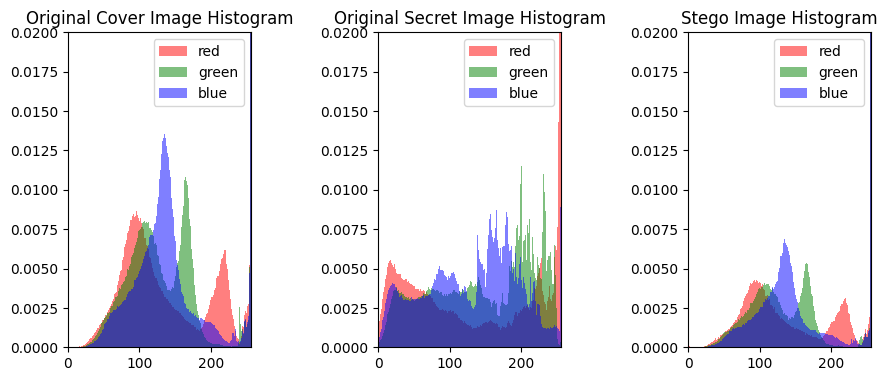

PSNR value: 3.2483693489165706


In [28]:
import math
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

def show_histograms(image1, title1, image2, title2, image3, title3):
    colors = ('red', 'green', 'blue')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

    for channel, color in enumerate(colors):
        data1 = image1[:, :, channel].ravel()
        data2 = image2[:, :, channel].ravel()
        data3 = image3[:, :, channel].ravel()
        ax1.hist(data1, bins=256, range=(0, 256), density=True, color=color, alpha=0.5, label=color)
        ax2.hist(data2, bins=256, range=(0, 256), density=True, color=color, alpha=0.5, label=color)
        ax3.hist(data3, bins=256, range=(0, 256), density=True, color=color, alpha=0.5, label=color)

    ax1.set_title(title1)
    ax1.set_xlim([0, 256])
    ax1.set_ylim([0, 0.02])
    ax1.legend()

    ax2.set_title(title2)
    ax2.set_xlim([0, 256])
    ax2.set_ylim([0, 0.02])
    ax2.legend()

    ax3.set_title(title3)
    ax3.set_xlim([0, 256])
    ax3.set_ylim([0, 0.02])
    ax3.legend()

    fig.tight_layout(pad=5)
    plt.show()

def perfect_square_thresholds(n):
    thresholds = [0]
    for i in range(1, n + 1):
        thresholds.append(int(i * i))
    return thresholds

def pvd(g, msg, n):
    g = np.array(g, dtype=float)
    d = g[0] - g[1]
    dap = abs(d)
    d1 = 0
    t = 0

    lb = np.array(perfect_square_thresholds(n))[:-1]
    ub = np.array(perfect_square_thresholds(n))[1:] - 1

    for i in range(len(lb)):
        if lb[i] <= dap <= ub[i]:
            n = ub[i] - lb[i] + 1
            t = int(np.log2(n))
            k = 0 if t == 0 else int(msg[:t], 2)
            d1 = k + lb[i]

    m = (abs(d1 - dap)) / 2

    if (g[0] >= g[1]) and (d1 > dap):
        p1 = g[0] + np.ceil(m)
        p2 = g[1] - np.floor(m)
    elif (g[0] < g[1]) and (d1 > dap):
        p1 = g[0] - np.floor(m)
        p2 = g[1] + np.ceil(m)
    elif (g[0] >= g[1]) and (d1 <= dap):
        p1 = g[0] - np.ceil(m)
        p2 = g[1] + np.floor(m)
    elif (g[0] < g[1]) and (d1 <= dap):
        p1 = g[0] + np.ceil(m)
        p2 = g[1] - np.floor(m)

    return p1, p2, t

def hide_image(cover_img, secret_img):
    height, width, channel = cover_img.shape
    cover_img = cover_img.astype(float)
    secret_img = secret_img.astype(float)
    stego_img = np.zeros_like(cover_img)

    for channels in range(channel):
        for row in range(0, height, 2):
            for col in range(0, width, 2):
                g = cover_img[row, col:col + 2, channels]
                msg = secret_img[row, col:col + 2, channels]
                msg = np.round(msg / 255)
                msg = msg.astype(int).flatten()
                msg_str = ''.join(str(x) for x in msg)
                p1, p2, _ = pvd(g, msg_str, 8)
                stego_img[row, col, channels] = p1
                stego_img[row, col + 1, channels] = p2

    return stego_img


def psnr(img1, img2):
    mse = np.mean((img1.astype(float) - img2.astype(float)) ** 2)

    if mse == 0:
        return float('inf')

    max_pixel = 255.0
    psnr_value = 10 * np.log10(max_pixel/ math.sqrt(mse))

    return psnr_value


cover_image = cv2.imread('filtered_1/00000000_(4).jpg')
secret_image = cv2.imread('filtered_1/00000045_(2).jpg')

stego_image = hide_image(cover_image, secret_image)
stego_image = stego_image.astype(np.uint8)
cv2.imwrite('stego_image.png', stego_image)

show_histograms(cover_image, 'Original Cover Image Histogram', secret_image,
                'Original Secret Image Histogram', stego_image, 'Stego Image Histogram')

psnr_value = psnr(cover_image, stego_image)
print('PSNR value:', psnr_value)